In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
# Laptop GPU is busy with rendering screen ...
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  
import pickle
import glob
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

## Read Data

In [2]:
data_dir = 'data/summerschool2020/Robot_Data/train/*'
file_list = sorted(glob.glob(data_dir))

dfs = []
for input_file in file_list:
    print('Loading:', input_file)
    dfs.append(pd.read_csv(input_file).drop(['data'], axis=1))

Loading: data/summerschool2020/Robot_Data/train/run1_diagonal.csv
Loading: data/summerschool2020/Robot_Data/train/run1_horizontal.csv
Loading: data/summerschool2020/Robot_Data/train/run1_vertical.csv
Loading: data/summerschool2020/Robot_Data/train/run2_diagonal.csv
Loading: data/summerschool2020/Robot_Data/train/run2_horizontal.csv
Loading: data/summerschool2020/Robot_Data/train/run2_vertical.csv
Loading: data/summerschool2020/Robot_Data/train/run3_diagonal.csv
Loading: data/summerschool2020/Robot_Data/train/run3_horizontal.csv
Loading: data/summerschool2020/Robot_Data/train/run3_vertical.csv


0 2565
1 1666
2 3114
3 5074
4 2458
5 2021
6 2364
7 1905
8 2229


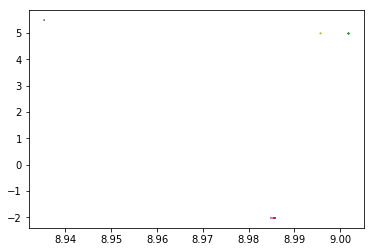

In [3]:
run_limit_dict = {
    0: 2500,
    1: 1666,
    2: 3020,
    3: 2250,
    4: 2458, # end
    5: 2021, # end
    6: 2290,
    7: 1700,
    8: 2050,
}

for i, df in enumerate(dfs):
    print(i, len(df.vicon_x))
    start = run_limit_dict[i] 
    end = 5000
    plt.plot(df.vicon_x[start:end], df.vicon_y[start:end])
    #print(np.sum(np.abs(np.diff(df.vicon_x[start:end])) > 1e-4))
    #print(np.sum(np.abs(np.diff(df.vicon_y[start:end])) > 1e-4))


In [4]:
from modules.data import KEYS as keys
from modules.data import get_data_from_data_frame
from modules.data import read_data


In [5]:
"""
Examplary code snippet for reading the data files provided
for the SFB Summerschool 2020 Robot Positioning Challenge.
"""


train = []
n_files = len(file_list)
y_list = []
t_list = []
X_list = []

data_pickle_file = 'data/train_pickle_file.pkl'

if os.path.exists(data_pickle_file):
    print('Reloading from pickle file')
    with open(data_pickle_file, 'rb') as handle:
         train, y_list, X_list, t_list = pickle.load(handle)
else:
    for file_index, file in enumerate(file_list):
        print('Loading:', file)
        
        frames, y, t, X = read_data(file)
            
        X_list.append(X)
        y_list.append(y)
        t_list.append(t)
        train.append(frames)
        
    # write data
    pickle_data = [train, y_list, X_list, t_list]
    with open(data_pickle_file, 'wb') as handle:
        pickle.dump(pickle_data, handle, protocol=2)

Reloading from pickle file


## Compute sensor normalization

Total number of frames: 23396
(1, 1, 10)
(1, 1, 10)
[-3.50604012e-04  9.59124973e-05 -1.89788316e-04 -2.70150821e-04
  8.33215782e-03  3.15803873e-03  1.69470456e-01 -1.06712757e-02
 -1.65546889e-01 -8.75976040e+01]
[ 1.09698073e-03  1.33473273e-04  1.50784583e-04 -9.61597568e-03
  7.77166722e-03 -3.51631145e-02 -7.22989529e-01 -4.76040218e-01
  5.91544435e-01 -8.13113104e+01]
[2.09377890e-03 2.08259567e-03 3.34850379e-03 1.36976443e-01
 1.32930981e-01 1.27254275e-01 2.75353289e+00 3.74382612e+00
 3.79243363e+00 1.35468189e+01]
[2.49188531e-03 3.24327573e-03 3.54679607e-03 1.38226065e-01
 1.35211767e-01 1.40882155e-01 4.31136393e+00 5.02773912e+00
 6.34990986e+00 1.17975588e+01]
Sensor normalization file: data/normalization/sensor_normalization_eqTrue_trTrue.pkl


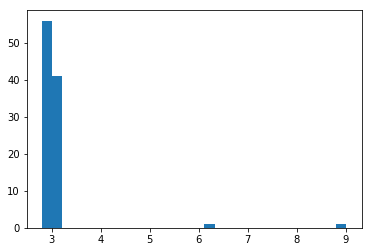

In [29]:
# --------
# settings
# --------
norm_use_training_data = True
treat_sensors_equally = False
# --------

if treat_sensors_equally:
    norm_axes = (0, 1, 2)
else:
    norm_axes = 0

sensor_norm = np.zeros_like(X_list[0][0])
num_frames = 0
X_concat = np.concatenate(X_list, axis=0)
sensor_bias = np.nanmean(
    X_concat, axis=norm_axes, keepdims=True)[0]
sensor_std = np.nanstd(
    X_concat, axis=norm_axes, keepdims=True)[0] + 1e-7
print('Total number of frames:', X_concat.shape[0])
print(sensor_bias.shape)
print(sensor_std.shape)


with open('data/normalization/norm_data_00000100.pkl', 'rb') as handle:
    t_norm, X_norm = pickle.load(handle, encoding='latin1')
    sensor_bias2 = np.nanmean(
        X_norm, axis=norm_axes, keepdims=True)[0]
    sensor_std2 = np.nanstd(
        X_norm, axis=norm_axes, keepdims=True)[0] + 1e-7
    t_diff = np.diff(t_norm, axis=0)
    plt.hist(t_diff, bins=30)
    
print(np.nanmean(X_concat, axis=(0, 1, 2)))
print(np.nanmean(X_norm, axis=(0, 1, 2)))

print(np.nanstd(X_concat, axis=(0, 1, 2)))
print(np.nanstd(X_norm, axis=(0, 1, 2)))

# save sensor normalization
if norm_use_training_data:
    pass
else:
    sensor_bias = sensor_bias2
    sensor_std = sensor_std2
    
sensor_norm_file = 'data/normalization/sensor_normalization_eq{}_tr{}.pkl'.format(
    treat_sensors_equally, norm_use_training_data)
if os.path.exists(sensor_norm_file):
    print('WARNING: File {} already exists. Aborting!'.format(
        sensor_norm_file))
else:
    with open(sensor_norm_file, 'wb') as handle:
        pickle.dump([sensor_bias, sensor_std], 
                    handle, protocol=2)

print('Sensor normalization file:', sensor_norm_file)


## Vicon Sensors

The sensors are arranged on a perfect rectangular 23x15 grid with distances of 1 in x-and y-direction.

In [7]:
vicon_file = 'data/summerschool2020/Robot_Data/Vicon_Node_Positions.csv'
df_vicon = pd.read_csv(vicon_file)

# get arrays of coordinates
vicon_coords = np.empty([23, 15, 2])
for strip_id in range(1, 24):
    for node_id in range(1, 16):
        mask = np.logical_and(
            df_vicon.strip_id == strip_id,
            df_vicon.node_id == node_id)
        vicon_coords[strip_id-1, node_id-1, 0] = df_vicon.vicon_x[mask]
        vicon_coords[strip_id-1, node_id-1, 1] = df_vicon.vicon_y[mask]
print(df_vicon.min())
print(df_vicon.max())
print(df_vicon.node_id.size, 23*15)
df_vicon.head()

strip_id     1.000
node_id      1.000
vicon_x    -11.185
vicon_y     -6.425
dtype: float64
strip_id    23.000
node_id     15.000
vicon_x     10.815
vicon_y      7.575
dtype: float64
345 345


,strip_id,node_id,vicon_x,vicon_y
0,1.0,1.0,-11.185,7.575
1,1.0,2.0,-11.185,6.575
2,1.0,3.0,-11.185,5.575
3,1.0,4.0,-11.185,4.575
4,1.0,5.0,-11.185,3.575


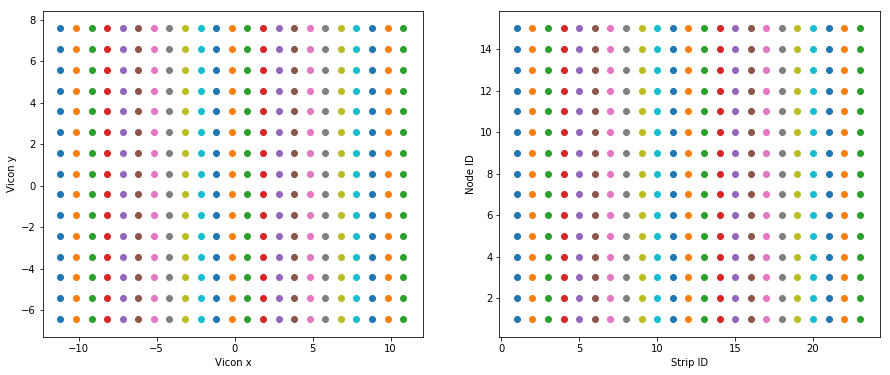

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
for strip_id in range(1, 24):
    mask = df_vicon.strip_id == strip_id
    #print(np.unique(np.diff(df_vicon.vicon_x[mask])))
    #print(np.unique(np.diff(df_vicon.vicon_y[mask])))
    if np.sum(mask) > 0:
        axes[0].scatter(df_vicon.vicon_x[mask], df_vicon.vicon_y[mask], 
                        label='Strip: {:02d}'.format(strip_id))
        axes[1].scatter(df_vicon.strip_id[mask], df_vicon.node_id[mask], 
                        label='Strip: {:02d}'.format(strip_id))
    axes[0].set_xlabel('Vicon x')
    axes[0].set_ylabel('Vicon y')
    axes[1].set_xlabel('Strip ID')
    axes[1].set_ylabel('Node ID')
    

## Define Helper Functions

In [9]:
decimals = 5

dict_coords = {}
dict_ids = {}
for index, row in df_vicon.T.items():
    x = np.round(row.vicon_x, decimals=decimals)
    y = np.round(row.vicon_y, decimals=decimals)
    dict_coords[(row.strip_id, row.node_id)] = (x, y)
    dict_ids[(x, y)] = (row.strip_id, row.node_id)
    
def get_ids(x, y):
    x = np.round(x, decimals=decimals)
    y = np.round(y, decimals=decimals)
    return dict_ids[(x, y)]

def get_coords(strip_id, row_id):
    if isinstance(strip_id, int):
        return dict_coords[(strip_id, row_id)]
    else:
        coords = [dict_coords[(s, r)] for s, r in zip(strip_id, row_id)]
        return np.array(coords).T


In [10]:
limit_dict = {
    'r': [-100, -1e-1],
    'ax': [-0.01, 0.01],
    'ay': [-0.01, 0.01],
    'az': [-0.01, 0.01],
    'gx': [-5, 5],
    'gy': [-5, 5],
    'gz': [-5, 5],
    'mx': [-400, 400],
    'my': [-400, 400],
    'mz': [-400, 400],
}

key_index = {key:i for i, key in enumerate(keys)}

def normalize(X):
    X_norm = np.array(X)
    X_norm = (X_norm - sensor_bias) / sensor_std
    return X_norm

def get_data(run, index, key, normalized):
    y = y_list[run][index]
    X = X_list[run][index]
    
    data = np.array(X[..., key_index[key]])
    data[~np.isfinite(data)] = -float('inf')
    
    if normalized:
        bias = sensor_bias[..., key_index[key]]
        std = sensor_std[..., key_index[key]]
        data = (data - bias) / std
    
    return y, X, data

def print_frame(index, run=0, 
                ax=None, fig=None, add_colorbar=True, 
                key='r', key_as_title=False,
                normalized=True,
                y_pred=None,
                empty_data=False):
    if ax is None:
        fig, ax = plt.subplots()
    
    # get data
    y, X, data = get_data(run, index, key, normalized)
    
    # get limits
    if normalized:
        limits = {
            'vmax': 7,
            'vmin': -7,
        }
    else:
        if key in limit_dict:
            limits = {
                'vmax': limit_dict[key][1],
                'vmin': limit_dict[key][0],
            }
        else:
            limits = {}

    if empty_data:
        data *= float('nan')
    
    pcmesh = ax.pcolormesh(
        vicon_coords[:, :, 0], 
        vicon_coords[:, :, 1], 
        data,
        cmap='RdBu',
        **limits)
    scat = ax.scatter(*y, marker='x', color='red', s=500)
    
    artists = [pcmesh, scat]
    if y_pred is not None:
        scat_pred = ax.scatter(
            *y_pred[index], marker='+', color='green', s=500)
        artists.append(scat_pred)
    
    if add_colorbar:
        fig.colorbar(pcmesh)
    if key_as_title:
        title = ax.set_title(key)
    else:
        title = ax.set_title('Run {} | Frame: {:05d}'.format(
            run, index))
    if ax is None:
        plt.show()
        plt.close(fig)
    return artists, ax, fig

def print_complete_frame(index, run=0, axes=None, 
                         fig=None, add_colorbar=True,
                         normalized=True,
                         empty_data=False,
                         add_title=True,
                         y_pred=None,
                        ):
    if axes is None:
        fig, axes = plt.subplots(2, 5, figsize=(20, 5))
    
    artists_list = []
    for ax, key in zip(axes.flatten(), keys):
        artists, _, _ = print_frame(
            index=index, run=run, ax=ax, fig=fig,
            add_colorbar=False, key=key,
            key_as_title=True, 
            normalized=normalized,
            y_pred=y_pred,
            empty_data=empty_data)
        artists_list.append(artists)
    if add_title:
        title = fig.suptitle('Run {} | Frame: {:05d}'.format(
            run, index))
    else:
        title = None
    fig.tight_layout()
    if axes is None:
        plt.show()
        plt.close(fig)
    return artists_list, title, fig, axes
    

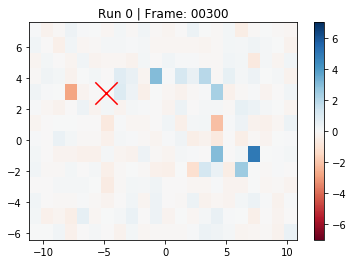

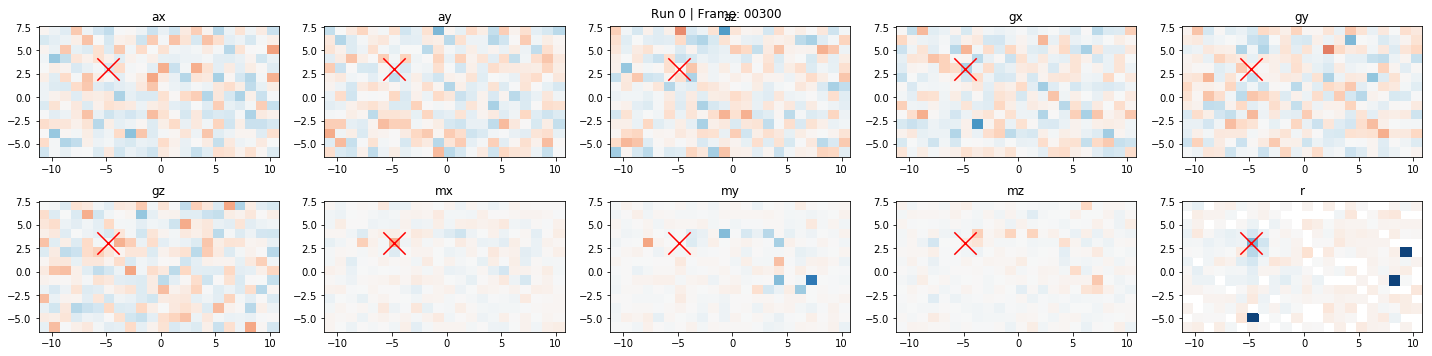

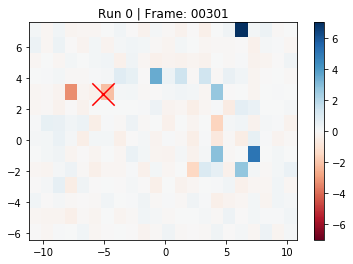

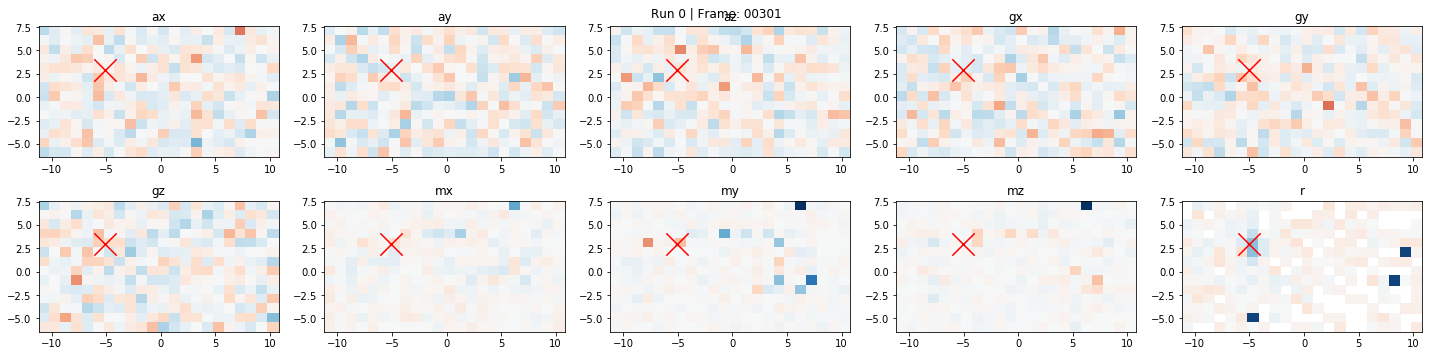

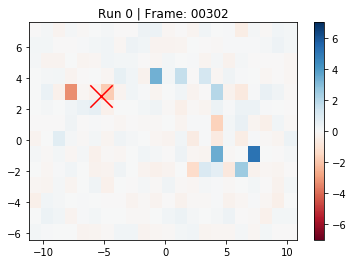

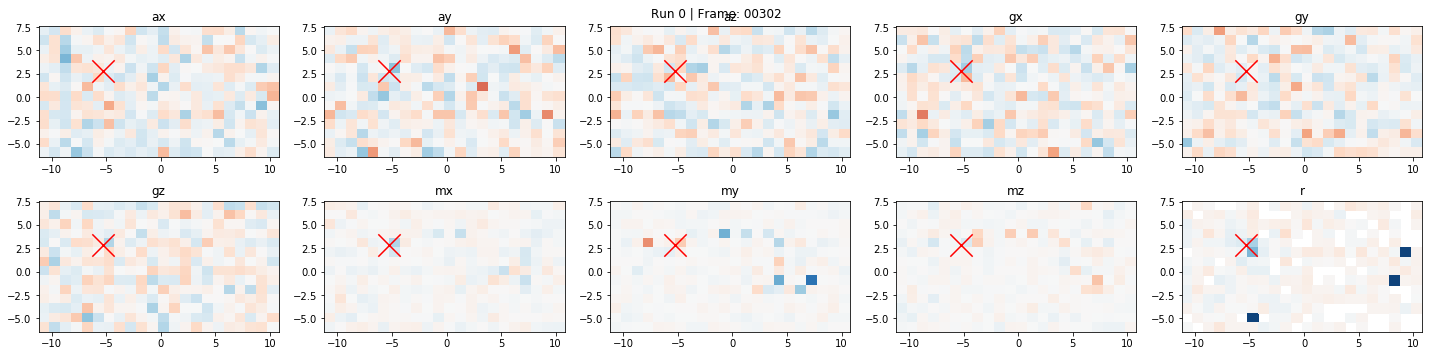

In [11]:
for i in range(300, 303):
    print_frame(i, run=0, key='my')
    print_complete_frame(i, run=0)


In [12]:
def create_y_gif(y_pred, y_true=None, 
                 file_name='plots/gif_y_prediction.gif'):
    fig, ax = plt.subplots()
    fig.set_tight_layout(True)
    
    num_frames = len(y_pred)
    
    plot_dir = os.path.dirname(file_name)
    if not os.path.isdir(plot_dir):
        print('Creating directory:', plot_dir)
        os.makedirs(plot_dir)
    
    # Plot axis that persists (isn't redrawn)
    title = ax.set_title('Frame: {:05d}'.format(0))
    ax.set_xlabel('Vicon X [meter]')
    ax.set_ylabel('Vicon Y [meter]')
    min_x = np.min(vicon_coords[..., 0])
    max_x = np.max(vicon_coords[..., 0])
    min_y = np.min(vicon_coords[..., 1])
    max_y = np.max(vicon_coords[..., 1])
    ax.set_xlim(min_x - 1, max_x + 1)
    ax.set_ylim(min_y - 1, max_y + 1)
    
    artists = [ax, title]
    
    if y_pred is not None:
        scat_pred = ax.scatter(
            0, 0, marker='+', color='green', s=500,
            label='Prediction',
        )
        artists.append(scat_pred)
    if y_true is not None:
        scat_true = ax.scatter(
            0, 0, marker='+', color='orange', s=500,
            label='True',
        )
        artists.append(scat_true)
    ax.legend()
    
    def init():
        return artists

    def update(i):
        # Update the line and the axes (with a new xlabel). Return a tuple of
        # "artists" that have to be redrawn for this frame.
        cnt = 2
        if y_pred is not None:
            scat_pred = artists[cnt]
            cnt += 1
            scat_pred.set_offsets(y_pred[i])
        if y_true is not None:
            scat_true = artists[cnt]
            cnt += 1
            scat_true.set_offsets(y_true[i])
        artists[1].set_text('Frame: {:05d}'.format(i))
        #artists[0].set_xlim(min_x - 1, max_x + 1)
        #artists[0].set_ylim(min_y - 1, max_y + 1)
        return artists

    # FuncAnimation will call the 'update' function for each frame; here
    # animating over 10 frames, with an interval of 200ms between frames.
    anim = FuncAnimation(
        fig, update, frames=tqdm(np.arange(0, num_frames)), 
        interval=200, blit=False, init_func=init)
    anim.save(file_name, dpi=80, writer='imagemagick')

def create_gif(key, run, file_name='plots/gif_run{run}_{key}.gif'):
    fig, ax = plt.subplots()
    fig.set_tight_layout(True)
    
    file_name = file_name.format(run=run, key=key)
    plot_dir = os.path.dirname(file_name)
    if not os.path.isdir(plot_dir):
        print('Creating directory:', plot_dir)
        os.makedirs(plot_dir)

    # Plot a scatter that persists (isn't redrawn) and the initial line.
    print_frame(i, run=run, ax=ax, fig=fig, key=key)

    def update(i):
        # Update the line and the axes (with a new xlabel). Return a tuple of
        # "artists" that have to be redrawn for this frame.
        artists = print_frame(
            i, run=run, ax=ax, fig=fig, 
            add_colorbar=False, key=key)
        return artists, ax

    # FuncAnimation will call the 'update' function for each frame; here
    # animating over 10 frames, with an interval of 200ms between frames.
    anim = FuncAnimation(fig, update, frames=tqdm(np.arange(0, min(100, len(frames)))), 
                         interval=200)
    anim.save(file_name, dpi=80, writer='imagemagick')

def create_complete_gif(run, file_name='plots/gif_run{run}{norm}.gif',
                        normalized=True, num_frames=100):
    fig, axes = plt.subplots(2, 5, figsize=(20, 5))
    fig.set_tight_layout(True)
    
    if normalized:
        norm = '_normalized'
    else:
        norm = ''
    file_name = file_name.format(run=run, norm=norm)
    plot_dir = os.path.dirname(file_name)
    if not os.path.isdir(plot_dir):
        print('Creating directory:', plot_dir)
        os.makedirs(plot_dir)

    # Plot a scatter that persists (isn't redrawn) and the initial line.
    print_complete_frame(i, run=run, axes=axes, fig=fig, 
                         normalized=normalized)
    def init():
        pass
    
    def update(i):
        # Update the line and the axes (with a new xlabel). Return a tuple of
        # "artists" that have to be redrawn for this frame.
        print_complete_frame(
            i, run=run, axes=axes, fig=fig,
            normalized=normalized)

    # FuncAnimation will call the 'update' function for each frame; here
    # animating over 10 frames, with an interval of 200ms between frames.
    anim = FuncAnimation(
        fig, update, 
        frames=tqdm(np.arange(0, min(num_frames, len(y_list[run])))), 
        interval=200, init_func=init)
    anim.save(file_name, dpi=80, writer='imagemagick')
    plt.close(fig)

def create_complete_gif2(run, file_name='plots/gif_run{run}{norm}.gif',
                         normalized=True, y_pred=None,
                         num_frames=100):
    fig, axes = plt.subplots(2, 5, figsize=(20, 5))
    fig.set_tight_layout(True)
    
    if normalized:
        norm = '_normalized'
    else:
        norm = ''
    file_name = file_name.format(run=run, norm=norm)
    plot_dir = os.path.dirname(file_name)
    if not os.path.isdir(plot_dir):
        print('Creating directory:', plot_dir)
        os.makedirs(plot_dir)

    # Plot a scatter that persists (isn't redrawn) and the initial line.
    artists_list, title, _, _ = print_complete_frame(
        0, run=run, axes=axes, fig=fig, 
        y_pred=y_pred,
        normalized=normalized, 
        add_title=False,
        empty_data=True)
    title = axes[0, 0].text(
        .45, 0.9, '', transform = axes[0, 0].transAxes)
    pcmesh_list = [a[0] for a in artists_list]
    scat_list = [a[1] for a in artists_list]
    all_artists = list(pcmesh_list)
    all_artists.extend(scat_list)
    if y_pred is not None:
        scat_pred_list = [a[2] for a in artists_list]
        all_artists.extend(scat_pred_list)
    all_artists.append(title)
    
    def init():
        return all_artists

    def update(i):
        # Update the line and the axes (with a new xlabel). Return a tuple of
        # "artists" that have to be redrawn for this frame.
        for j, key in enumerate(keys):
            # get new data
            y, X, data = get_data(
                run=run, index=i, key=key, normalized=normalized)
            
            # set new data
            if y_pred is None:
                pcmesh, scat = artists_list[j]
            else:
                pcmesh, scat, scat_pred = artists_list[j]
                scat_pred.set_offsets(
                    [y_pred[i, 0], y_pred[i, 1]])
            pcmesh.set_array(data[:-1,:-1].ravel())
            scat.set_offsets([y[0], y[1]])
            
            title.set_text('Run {} | Frame: {:05d}'.format(
                run, i))

        return all_artists

    # FuncAnimation will call the 'update' function for each frame; here
    # animating over 10 frames, with an interval of 200ms between frames.
    anim = FuncAnimation(
        fig, update, 
        frames=tqdm(np.arange(0, min(num_frames, len(y_list[run])))), 
        interval=200, blit=True, init_func=init)
    anim.save(file_name, dpi=80, writer='imagemagick')
    plt.close(fig)

Creating Run 0 with normalization True



Creating Run 1 with normalization True



Creating Run 2 with normalization True



Creating Run 0 with normalization False


KeyboardInterrupt: 

/home/mirco/virtualenv/tensorflow2_python3/lib/python3.5/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


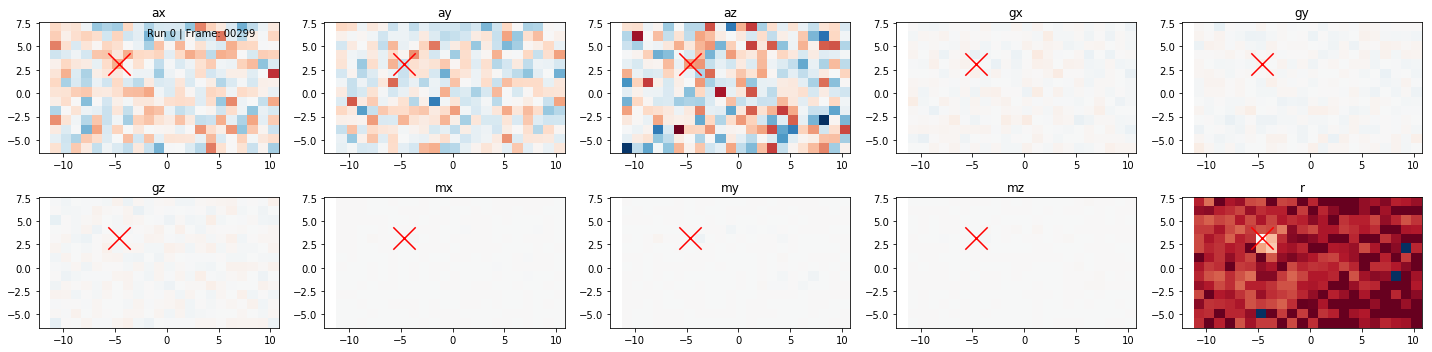

In [13]:
for normalized in [True, False]:
    for run in range(3):
        print('Creating Run {} with normalization {}'.format(
            run, normalized))
        create_complete_gif2(
            run, normalized=normalized, num_frames=300)

## Investigate Value Distributions

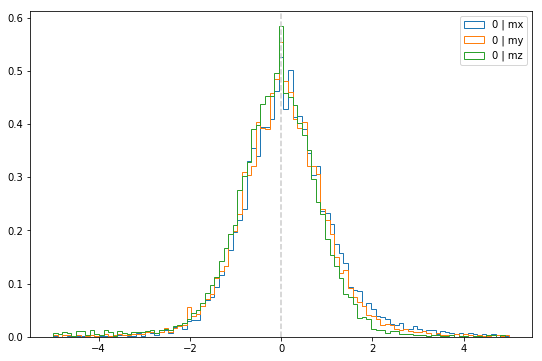

In [14]:
bins = np.linspace(-5, 5, 100)

fig, ax = plt.subplots(figsize=(9, 6))
for run in range(1):
    for key in keys[6:9]:
        X_norm = normalize(X_list[run])
        X_norm = X_list[run]
        ax.hist(X_norm[..., key_index[key]].flatten(),
                bins=bins, histtype='step',
                label='{} | {}'.format(run, key),
                density=True,
               )
ax.legend()
ax.axvline(0, color='0.8', ls='--')
#ax.set_yscale('log')
        

In [15]:
df_data = train[0][12]['data']
df_data2 = train[0][13]['data']
df_data.head()

,ax,ay,az,gx,gy,gz,mx,my,mz,node_id,r,strip_id,timestamp
0,-0.000289,-0.001853,0.003434,0.232774,-0.157319,-0.010905,0.073723,-0.372346,-0.599570,1,-83.0,1,2020-08-05 14:01:21.406
1,0.000243,-0.000251,-0.003669,-0.176132,0.056153,0.021943,0.684286,0.853457,1.164057,2,-90.0,1,2020-08-05 14:01:21.442
10,-0.000779,-0.002037,0.003085,-0.003891,-0.068929,-0.165998,1.293208,-1.216587,0.685460,11,-83.0,1,2020-08-05 14:01:21.486
100,-0.000638,-0.000445,-0.002700,-0.198548,0.001200,-0.014202,-0.386873,-1.395792,0.680745,11,-89.0,7,2020-08-05 14:01:21.471
101,-0.000255,-0.000909,-0.005886,0.015603,-0.039095,0.088345,-0.717027,1.107362,1.403070,12,-94.0,7,2020-08-05 14:01:21.443


#### Investigate Time Steps

Times between steps seems to be roughly constant and around 0.23 seconds. 

In [16]:
run = 8
if False:
    num_frames = len(train[run])
    times = np.empty(num_frames)
    offset = 2459067
    for i in tqdm(range(num_frames)):
        time_stamps = train[run][i]['data'].timestamp
        time_i = []
        for time_stamp in time_stamps:
            time_i.append(time_stamp.to_julian_date()- offset)
        times[i] = np.mean(time_i)  * 24 * 60 * 60
else:
    times = t_list[run][:, 0]
    

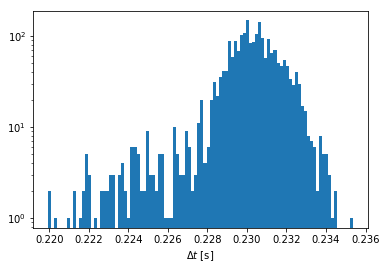

In [17]:
time_diffs = np.diff(times)
plt.hist(time_diffs, bins=100)
plt.xlabel('$\Delta t$ [s]')
plt.yscale('log')
plt.show()


## Fit Kernel Density for Velocity and Acceleration

In [18]:
from sklearn.neighbors import KernelDensity
from scipy.optimize import minimize
from scipy.interpolate import UnivariateSpline
from egenerator.utils import basis_functions

from modules.data import get_vel_and_acc


def get_kde_data(every_nth):
    y_train_list = []
    t_train_list = []
    for train_index in range(8):
        t_train = np.array(t_list[train_index])[::every_nth]
        y_train = np.array(y_list[train_index])[::every_nth]
        t_train_list.append(t_train)
        y_train_list.append(y_train)

    y = np.concatenate(y_train_list, axis=0)
    t = np.concatenate(t_train_list, axis=0)
    return y, t

def build_kde(every_nth, 
              kernel='linear', 
              bandwidth=0.005,
              atol=1e-2,
              rtol=1e-1,
              sparsity=1,
             ):
    pos, t = get_kde_data(every_nth)
    vel_abs, acc_abs, acc_parallel, acc_perp = \
        get_vel_and_acc(pos, t)

    acc_perp_abs = np.abs(acc_perp)

    kde_data = np.concatenate(
        [
            #acc_perp_abs, 
            #acc_parallel, 
            vel_abs,
        ],
        axis=1,
    )
    
    # shuffle so that randomly chosing points via sparsity
    # obtains uncorrelated points
    np.random.shuffle(kde_data)
    
    kde = KernelDensity(
        kernel=kernel, bandwidth=bandwidth,
        atol=atol, rtol=rtol,
    ).fit(kde_data[::sparsity])
    return kde

def eval_mixture_model(x, params):
    
    # normalize scale
    params[:, 3] /= np.sum(params[:, 3])

    llh = np.log(np.sum(basis_functions.asymmetric_gauss(
        x, 
        mu=params[:, 0], 
        sigma=params[:, 1], 
        r=params[:, 2],
    ) * params[:, 3], axis=1))
    return llh

def get_mixture_model(x, n=3):
    """Get a mixture model for the 1D data x
    Parameters:
    -----------
    x: array_like
        The data for which to build the mixture model.
    n: int
        The number of asymmetric Gaussians to use.
        
    Returns:
    -------
    function:
        The mixture model function:
        f(x) -> log prob
    """
    def loss(params):
        params = np.reshape(params, [n, 4])
        
        # make sure sigma and r are positive
        if (params[:, 1:3] <= 1e-8).any():
            return np.inf
        
        neg_llh = -eval_mixture_model(x, params)
        return np.sum(neg_llh)
    
    params = np.empty([n, 4])
    params[:, 0] = np.linspace(0, 0.707, n)
    params[:, 1:] = 1.
    params[0, 1] = 0.0001
    params[0, 2] = 100
    params[-1, 1] = 100
    params[-1, 2] = 0.01
    params = params.flatten()
    result = minimize(
        fun=loss,
        x0=params,
        method='Nelder-Mead',
    )
    params = np.reshape(result.x, [n, 4])
    
    def mixture_model(x):
        return eval_mixture_model(x, params)
    
    return mixture_model
    
def build_mm(every_nth, n=1):
    pos, t = get_kde_data(every_nth)
    vel_abs, acc_abs, acc_parallel, acc_perp = \
        get_vel_and_acc(pos, t)

    acc_perp_abs = np.abs(acc_perp)
    
    mm = get_mixture_model(vel_abs, n)
    return mm

def build_spline(every_nth):
    pos, t = get_kde_data(every_nth)
    vel_abs, acc_abs, acc_parallel, acc_perp = \
        get_vel_and_acc(pos, t)

    vel_abs_sorted = np.sort(vel_abs[:, 0])
    x = vel_abs_sorted[::100]
    
    hist, bin_edges = np.histogram(vel_abs, bins=x, density=True)
    x_mids = bin_edges[:-1] + np.diff(bin_edges)*0.5
    weights = np.ones_like(x_mids)
   # weights[x_mids < 0.01] = 10
   # weights[np.abs(x_mids - 0.7105) < 0.02 ] = 10
    
    s =  1e6 * len(weights) / len(vel_abs)**2
    
    spline = UnivariateSpline(
        x_mids, hist, s=s, k=2, ext=1, w=weights)
    return spline

kdes = [build_kde(e) for e in tqdm(range(1, 26))]
splines = [build_spline(e) for e in tqdm(range(1, 26))]
#mixture_models = {e: build_mm(e) for e in tqdm(range(1, 13))}

def write_to_file(data, file_name):
    file_dir = os.path.dirname(file_name)

    if not os.path.exists(file_dir):
        print('Creating directory:', file_dir)
        os.makedirs(file_dir)

    with open(file_name, 'wb') as handle:
        pickle.dump(data, handle, protocol=2)
        
# ------------------------------
# write kdes and splines to file
# ------------------------------
write_to_file(kdes, 'data/kdes/kde_vel_abs.pkl')
write_to_file(splines, 'data/splines/spline_vel_abs.pkl')


/home/mirco/virtualenv/tensorflow2_python3/lib/python3.5/site-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


kde_data (10585, 3)


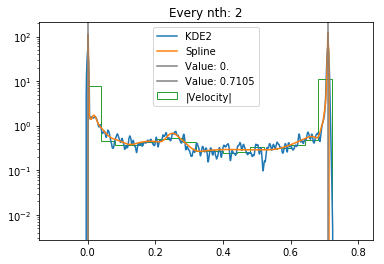

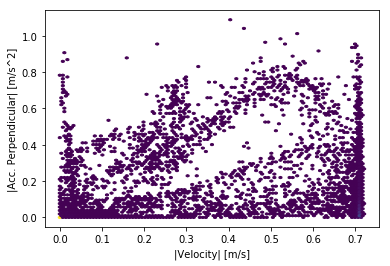

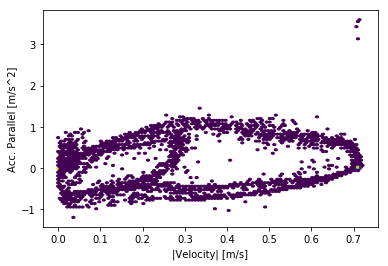

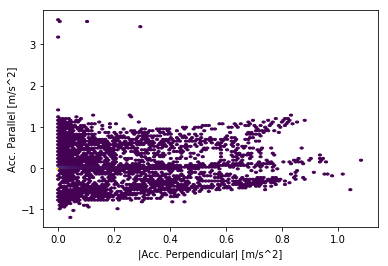

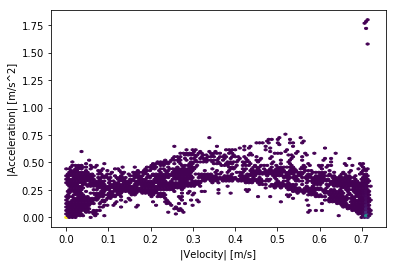

In [19]:
nth = 2

pos, t = get_kde_data(nth)
vel_abs, acc_abs, acc_parallel, acc_perp = \
    get_vel_and_acc(pos, t)

acc_perp_abs = np.abs(acc_perp)

kde_data = np.concatenate(
    [acc_perp_abs, acc_parallel, vel_abs],
    axis=1,
)
print('kde_data', kde_data.shape)

kde = KernelDensity(
    kernel='epanechnikov', bandwidth=0.01).fit(vel_abs)
    #kernel='gaussian', bandwidth=0.0000015).fit(vel_abs)

x = np.linspace(-0.1, 0.8, 1000)
bins = np.linspace(-0.1, 0.8, 100)
#plt.plot(x, np.exp(kde.score_samples(x[:, None])), label='KDE')
plt.plot(x, np.exp(kdes[nth].score_samples(x[:, None])), label='KDE2')
plt.plot(x, splines[nth](x), label='Spline')
#plt.plot(x, np.exp(mixture_models[1](x[:, None])), label='MM')

plt.hist(vel_abs, bins='doane', label='|Velocity|',
         density=True, histtype='step')
#plt.hist(acc_parallel, bins=100, label='Par. Acc.',
#         density=True, histtype='step')
#plt.hist(acc_perp_abs, bins=100, label='|Perp. Acc.|',
#         density=True, histtype='step')
#plt.hist(acc_abs, bins=100, label='Abs Acc.',
#         density=True, histtype='step')
#plt.ylim(0, 10)
plt.axvline(0., color='0.5', label='Value: 0.')
plt.axvline(0.7105, color='0.5', label='Value: 0.7105')
#plt.xlim(.69, 0.73)
#plt.xlim(-0.001, 0.1)
plt.yscale('log')
plt.title('Every nth: {}'.format(nth))
plt.legend()
plt.show()

#plt.hexbin(vel_abs[:-1], acc_perp[1:], mincnt=1)
plt.hexbin(vel_abs, np.abs(acc_perp), mincnt=1)
plt.xlabel('|Velocity| [m/s]')
plt.ylabel('|Acc. Perpendicular| [m/s^2]')
plt.show()

plt.hexbin(vel_abs, acc_parallel, mincnt=1)
plt.xlabel('|Velocity| [m/s]')
plt.ylabel('Acc. Parallel [m/s^2]')
plt.show()

plt.hexbin(np.abs(acc_perp), acc_parallel, mincnt=1)
plt.xlabel('|Acc. Perpendicular| [m/s^2]')
plt.ylabel('Acc. Parallel [m/s^2]')
plt.show()

plt.hexbin(vel_abs, acc_abs, mincnt=1)
plt.xlabel('|Velocity| [m/s]')
plt.ylabel('|Acceleration| [m/s^2]')
plt.show()


## Collect Data for sensor-based Model

In [20]:
every_nth = 2

X_train_list = []
X_llh_list = []
y_vel_list = []
y_acc_list = []
y_acc_parallel_list = []
y_acc_perp_list = []
for train_index in range(8):
    X_train = np.array(X_list[train_index])[::every_nth]
    t_train = np.array(t_list[train_index])[::every_nth]
    y_train = np.array(y_list[train_index])[::every_nth]
    
    vel_abs, acc_abs, acc_parallel, acc_perp = \
        get_vel_and_acc(y_train, t_train)
    
    dt = np.diff(t_train, axis=0)

    y_pos = np.array(y_train)
    y_vel = np.zeros_like(y_pos)
    y_vel[1:] = np.diff(y_pos, axis=0) / dt
    y_acc = np.zeros_like(y_pos)
    y_acc[1:] = np.diff(y_vel, axis=0) / dt

    # compute relative positions to each sensor
    y_pos_rel = (
        np.expand_dims(vicon_coords, axis=0) - 
        np.reshape(y_pos, [-1, 1, 1, 2])
    )


    # gather input data for LLH model
    y_vel_exp = np.tile(np.reshape(y_vel, [-1, 1, 1, 2]),
                        [1, 23, 15, 1])
    X_llh = np.concatenate([y_pos_rel, y_vel_exp], axis=-1)
    
    X_train_list.append(X_train)
    X_llh_list.append(X_llh)
    y_vel_list.append(y_vel)
    y_acc_list.append(y_acc)
    y_acc_perp_list.append(acc_perp)
    y_acc_parallel_list.append(acc_parallel)

X_llh = np.concatenate(X_llh_list, axis=0)
X_train = np.concatenate(X_train_list, axis=0)
y_acc = np.concatenate(y_acc_list, axis=0)
y_vel = np.concatenate(y_vel_list, axis=0)
y_acc_parallel = np.concatenate(y_acc_parallel_list, axis=0)
y_acc_perp = np.concatenate(y_acc_perp_list, axis=0)

X_llh_mean = np.mean(X_llh, axis=0, keepdims=True)
X_llh_std = np.std(X_llh, axis=0, keepdims=True)

X_train_norm = (X_train - sensor_bias) / (sensor_std*10)
# set NaN values to 0
X_train[~np.isfinite(X_train)] = 0.
X_train_norm[~np.isfinite(X_train)] = 0.

print('vicon_coords', vicon_coords.shape)
print('y_pos_rel', y_pos_rel.shape)
print('y_vel', y_vel.shape)
print('y_pos', y_pos.shape)
print('y_vel_exp', y_vel_exp.shape)
print('X_llh', X_llh.shape)
print('X_llh_mean', X_llh_mean.shape)


vicon_coords (23, 15, 2)
y_pos_rel (953, 23, 15, 2)
y_vel (10585, 2)
y_pos (953, 2)
y_vel_exp (953, 23, 15, 2)
X_llh (10585, 23, 15, 4)
X_llh_mean (1, 23, 15, 4)


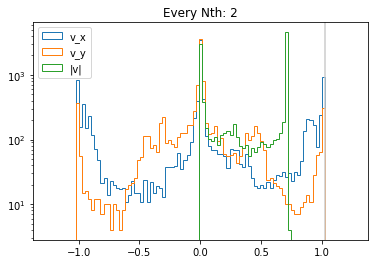

In [21]:
bins = np.linspace(-1.25, 1.25, 100)
#bins = np.linspace(0.99, 1.03, 100)
plt.hist(y_vel[:, 0], bins=bins, label='v_x',
         histtype='step')
plt.hist(y_vel[:, 1], bins=bins, label='v_y',
         histtype='step')
plt.hist(np.hypot(y_vel[:, 0], y_vel[:, 1]) / np.sqrt(2.), 
         bins=bins, label='|v|',
         histtype='step')
plt.axvline(1.02, color='0.8')
plt.legend()
plt.title('Every Nth: {}'.format(every_nth))
plt.yscale('log')

#### Investigate changes in velocity (Acceleration)

every_nth: 2
0.488 |acc|
0.659 |acc_perp|
0.764 -acc parallel
1.022 +acc parallel


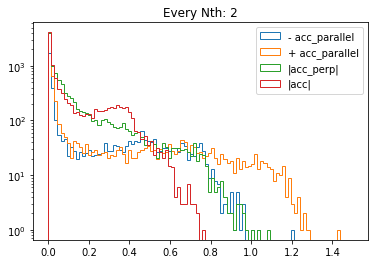

In [22]:
bins = np.linspace(-1.5, 1.5, 100)
bins = np.linspace(0, 1.5, 100)
#plt.hist(y_acc[:, 0], bins=bins, label='acc_x',
#         histtype='step')
#plt.hist(y_acc[:, 1], bins=bins, label='acc_y',
#         histtype='step')
#plt.hist(y_acc_parallel, bins=bins, label='acc_parallel',
#         histtype='step')
plt.hist(-y_acc_parallel[y_acc_parallel < 0], bins=bins, 
         label='- acc_parallel', histtype='step')
plt.hist(y_acc_parallel[y_acc_parallel > 0], bins=bins, 
         label='+ acc_parallel', histtype='step')
#plt.hist(-y_acc_parallel, bins=bins, label='-acc_parallel',
#         histtype='step')
#plt.hist(y_acc_perp, bins=bins, label='acc_perp',
#         histtype='step')
plt.hist(np.abs(y_acc_perp), bins=bins, label='|acc_perp|',
         histtype='step')
plt.hist(np.hypot(y_acc[:, 0], y_acc[:, 1]) / np.sqrt(2.), 
         bins=bins, label='|acc|',
         histtype='step')
plt.legend()
plt.title('Every Nth: {}'.format(every_nth))
plt.yscale('log')

def print_q(label, values):
    try:
        values = values[:, 0]
    except:
        pass
    values = sorted(values)
    num = int(len(values) * 0.975)
    print('{:3.3f} {}'.format(values[num], label))

print('every_nth:', every_nth )
print_q('|acc|', np.hypot(y_acc[:, 0], y_acc[:, 1]) / np.sqrt(2.))
print_q('|acc_perp|', np.abs(y_acc_perp))
print_q('-acc parallel', 
        -y_acc_parallel[y_acc_parallel <= 0])
print_q('+acc parallel', 
        +y_acc_parallel[y_acc_parallel >= 0])


#### Investigate Regularization Function

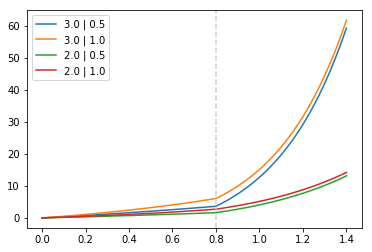

In [23]:
from modules.model import reg_acc_abs

x = np.linspace(0, 1.4, 100)
for h in [3., 2.]:
    for s in [0.5, 1.0]:
        plt.plot(x, reg_acc_abs(x, 0.8, h, s),
                 label='{:3.1f} | {:3.1f}'.format(h, s))
plt.axvline(0.8, color='0.8', ls='--')
plt.legend()
#plt.yscale('log')


0.7211487928805652
1.7958837089524107


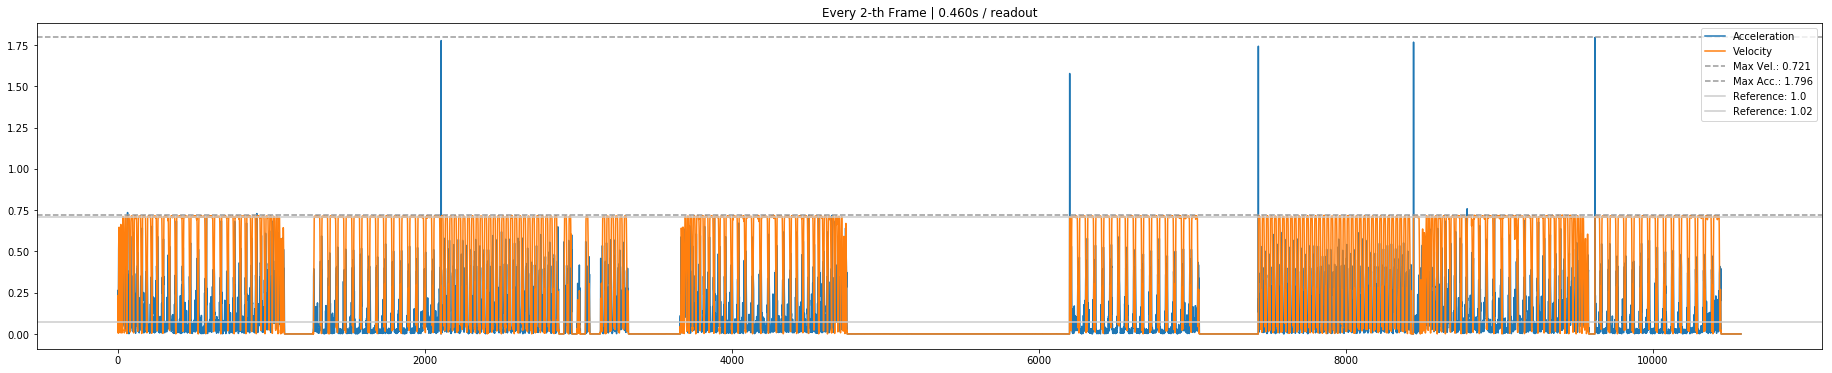

In [24]:
# start index
s = 10
fig, ax = plt.subplots(figsize=(32, 6))
ax.plot(np.hypot(y_acc[s:, 0], y_acc[s:, 1]) / np.sqrt(2.), 
         label='Acceleration')
ax.plot(np.hypot(y_vel[s:, 0], y_vel[s:, 1]) / np.sqrt(2.), 
         label='Velocity')
max_acc = np.max(np.hypot(y_acc[s:, 0], y_acc[s:, 1]) / np.sqrt(2.))
max_vel = np.max(np.hypot(y_vel[s:, 0], y_vel[s:, 1]) / np.sqrt(2.))
ax.axhline(max_vel, ls='--', color='0.6', 
           label='Max Vel.: {:3.3f}'.format(max_vel))
ax.axhline(max_acc, ls='--', color='0.6', 
           label='Max Acc.: {:3.3f}'.format(max_acc))
ax.axhline(.707, ls='-', color='.8', label='Reference: 1.0')
ax.axhline(.0717, ls='-', color='.8', label='Reference: 1.02')
ax.legend()
ax.set_title('Every {}-th Frame | {:3.3f}s / readout'.format(
    every_nth, 0.23*every_nth))
print(max_vel)
print(max_acc)


#### Investigate per-Sensor Data

(10585, 23, 15)


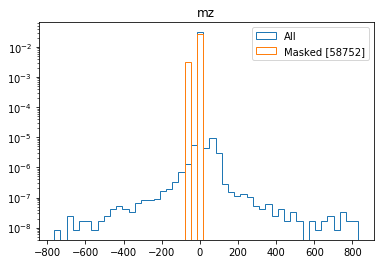

In [25]:
X_train.shape
X_llh.shape

mask = np.logical_and(
    np.abs(X_llh[..., 0]) < 1.5,
    np.abs(X_llh[..., 1]) < 1.5,
)
mask = np.logical_and(
    mask,
    np.hypot(X_llh[..., 2], X_llh[..., 3]) / np.sqrt(2.) > 0.2,
    #np.hypot(X_llh[..., 2], X_llh[..., 3]) / np.sqrt(2.) < 0.01,
)
print(mask.shape)

index = 8
bins = np.linspace(np.nanmin(X_train[..., index]), 
                   np.nanmax(X_train[..., index]), 50)
plt.hist(X_train[..., index].flatten(), 
         histtype='step',
         bins=bins, label='All', density=True)
plt.hist(X_train[mask][index], 
         histtype='step',
         bins=bins, 
         label='Masked [{}]'.format(np.sum(mask)), 
         density=True)
plt.legend()
plt.title(keys[index])
plt.yscale('log')


## Model Signal Term

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from tfscripts import layers as tfs
from tfscripts.compat.v1 import layers as tfs_compat
from egenerator.utils import basis_functions

num_filters_list = [4, 50, 50, 12]
filter_size_list = [[1, 1], [1, 1], [1, 1], [1, 1]]
activation_list = ['elu', 'elu', 'elu', '']
use_residual_list = [True, True, True, False]
method_list = ['locally_connected',
               'convolution', 'convolution', 'convolution']

class LLHModel(layers.Layer):
    
    def __init__(self):
        super(LLHModel, self).__init__()

        self.conv_layers = tfs.ConvNdLayers(
            input_shape=[-1, 23, 15, 4],
            filter_size_list=filter_size_list,
            num_filters_list=num_filters_list,
            activation_list=activation_list,
            use_residual_list=use_residual_list,
            method_list=method_list,
        )
        self.trainable_variables2 = self.conv_layers.trainable_variables
        self.variables2 = self.conv_layers.variables
    
    def call(self, x):
        conv_out = self.conv_layers(x, is_training=False)[-1]
        conv_out = tf.reshape(conv_out, [-1, 23, 15, 4, 3])
        
        mu, sigma, r = tf.unstack(conv_out, axis=-1)
        
        sigma = tf.nn.elu(sigma/100.) + 1.001
        r = tf.nn.elu(r/1000.) + 1.001
        
        conv_out = tf.stack([mu, sigma, r], axis=-1)
        return conv_out

conv_model = LLHModel()
llh_model = models.Sequential()
#inputs = tf.keras.Input(shape=[23, 15, 4], name='inputs')
llh_model.add(layers.InputLayer(input_shape=(23, 15, 4)))
llh_model.add(conv_model)
llh_model.summary()


In [ ]:
def loss_fun(y_true, y_pred):
    
    #y_true = tf.expand_dims(y_true, axis=-1)
    mu = y_pred[..., 0]
    sigma = y_pred[..., 1]
    r = y_pred[..., 2]
    
    mask = tf.math.is_finite(y_true)
    #mask = tf.logical_and(
    #    mask,
    #    tf.abs(y_true[..., 3, tf.newaxis]) < 15,
    #)
    y_true = tf.where(
        mask,
        y_true,
        tf.zeros_like(y_true)
    )
    loss = tf.where(
        mask,
        -basis_functions.tf_log_gauss(
            y_true, mu=mu, sigma=sigma),
        #-basis_functions.tf_log_asymmetric_gauss(
        #    y_true, mu=mu, sigma=sigma, r=r),
        #(y_true - mu)**2,
        tf.zeros_like(y_true),
    )
    loss = tf.reduce_mean(loss) 
    return loss

llh_model.compile(optimizer='adam', loss=loss_fun)

In [ ]:
print(np.isfinite(X_llh).all())
print(np.isfinite(X_train).all())
print(np.min(X_train), np.max(X_train), np.mean(X_train))
print(y_pos_rel.shape)
rel_dist = np.hypot(y_pos_rel[..., 0], y_pos_rel[..., 1]) / np.sqrt(2.)
X_llh_norm = (X_llh - X_llh_mean) / X_llh_std
#X_train[rel_dist > 3] = float('nan')
print(np.sum(rel_dist < 6))
history = llh_model.fit(x=X_llh_norm, y=X_train[..., 6:],
                        batch_size=32,
                        epochs=50, validation_split=0.2)

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')


In [ ]:
X_pred = llh_model.predict(X_llh_norm)
print('X_pred', X_pred.shape)
s = 20
d = 8
print(rel_dist[0, s, d])
print(X_train[0, s, d, 6:])
print(X_pred[0, s, d, :, 0])
print(X_pred[0, s, d, :, 1])
print(X_train[0, s, d, 6:] - X_pred[0, s, d, :, 0])

X_diff = X_pred[..., 0] - X_train[..., 6:]
X_pull = X_diff/ X_pred[..., 1]
bins = np.linspace(np.nanmin(X_pull), np.nanmax(X_pull), 100)
#bins = np.linspace(-10, 10, 100)
h = plt.hist(X_pull.flatten(), bins=bins, density=True)
plt.plot(bins, basis_functions.gauss(bins, mu=0, sigma=1))
plt.yscale('log')
plt.ylim(1e-10, max(h[0]))
plt.show()

## Predict with basic CNN

In [25]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from egenerator.utils import basis_functions


In [106]:
def limit_sigma(y_pred):
    mu = y_pred[..., :2]
    sigma = y_pred[..., 2:4]
    r = y_pred[..., 4:]
    sigma = tf.nn.elu(sigma) + 1.001
    r = tf.nn.elu(r) + 1.001
    y_pred = tf.concat([mu, sigma, r], axis=-1)
    return y_pred


model_name = 'coords'
add_coordinates = True

num_inputs = 4
if add_coordinates:
    num_inputs = 6

model = models.Sequential()
model.add(layers.InputLayer(input_shape=(23, 15, num_inputs))) 

if model_name == 'basic':
    model.add(layers.Dropout(rate=0.01)) 
    model.add(layers.Conv2D(8, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.Conv2D(16, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(16, (3, 3), activation='elu',
                            padding='same'))
    model.add(layers.Conv2D(16, (3, 3), activation='elu',
                            padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(16, (3, 3), activation='elu',
                            padding='same'))
    model.add(layers.Conv2D(32, (3, 3), activation='elu',
                            padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='elu'))
    
    optimizer = tf.optimizers.Adam(
        learning_rate=0.001,
        amsgrad=False,
    )
    batch_size = 32
    epochs = 20
    
elif model_name == 'test':
    model.add(layers.Dropout(rate=0.01)) 
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.Dropout(rate=0.05)) 
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='elu',
                            padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='elu',
                            padding='same'))
    model.add(layers.Dropout(rate=0.05)) 
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='elu',
                            padding='same'))
    model.add(layers.Dropout(rate=0.05)) 
    model.add(layers.Conv2D(64, (3, 3), activation='elu',
                            padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(rate=0.05)) 
    model.add(layers.Dense(128, activation='elu'))
    model.add(layers.Dense(128, activation='elu'))
    
    optimizer = tf.optimizers.Adam(
        learning_rate=0.0001,
        amsgrad=True,
    )
    batch_size = 1
    epochs = 50 #25 (current best)#20

elif model_name == 'augmented':
    model.add(layers.Dropout(rate=0.01)) 
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.Dropout(rate=0.05)) 
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='elu',
                            padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='elu',
                            padding='same'))
    model.add(layers.Dropout(rate=0.05)) 
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='elu',
                            padding='same'))
    model.add(layers.Dropout(rate=0.05)) 
    model.add(layers.Conv2D(64, (3, 3), activation='elu',
                            padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(rate=0.05)) 
    model.add(layers.Dense(128, activation='elu'))
    model.add(layers.Dense(128, activation='elu'))
    
    optimizer = tf.optimizers.Adam(
        learning_rate=0.0001,
        amsgrad=True,
    )
    batch_size = 1
    epochs = 25 
    
elif model_name == 'coords':
    #model.add(layers.Dropout(rate=0.01)) 
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    #model.add(layers.Dropout(rate=0.05)) 
    #model.add(layers.SpatialDropout2D(rate=0.05)) 
    model.add(layers.AveragePooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='elu',
                            padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='elu',
                            padding='same'))
    #model.add(layers.Dropout(rate=0.05)) 
    #model.add(layers.SpatialDropout2D(rate=0.05)) 
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.AveragePooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='elu',
                            padding='same'))
    #model.add(layers.Dropout(rate=0.05)) 
    model.add(layers.Conv2D(64, (3, 3), activation='elu',
                            padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='elu', 
                            padding='same'))
    model.add(layers.AveragePooling2D((2, 2)))
    model.add(layers.Flatten())
    #model.add(layers.Dropout(rate=0.05)) 
    model.add(layers.Dense(128, activation='elu'))
    model.add(layers.Dense(128, activation='elu'))
    
    optimizer = tf.optimizers.Adam(
        learning_rate=0.0001,
        amsgrad=True,
    )
    batch_size = 1
    epochs = 35 
else:
    raise ValueError
model.add(layers.Dense(6))    
model.add(layers.Lambda(limit_sigma))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 23, 15, 64)        3520      
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 23, 15, 64)        36928     
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 23, 15, 64)        36928     
_________________________________________________________________
average_pooling2d_9 (Average (None, 11, 7, 64)         0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 11, 7, 64)         36928     
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 11, 7, 64)         36928     
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 11, 7, 64)        

In [107]:
from modules.model import loss_fun

model.compile(optimizer=optimizer, loss=loss_fun)

In [108]:
X_train_list = []
y_train_list = []
t_train_list = []
for train_index in range(8):
    X_train = np.array(X_list[train_index])
    X_train = (X_train - sensor_bias) / sensor_std
    X_train[~np.isfinite(X_train)] = 0
    y_train = np.array(y_list[train_index])
    t_train = np.array(t_list[train_index])
    
    # limit frame numbers
    end = run_limit_dict[train_index] 
    X_train = X_train[:end]
    y_train = y_train[:end]
    t_train = t_train[:end]
    
    X_train_list.append(X_train[..., 6:])
    y_train_list.append(y_train)
    t_train_list.append(t_train)
    
X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
t_train = np.concatenate(t_train_list, axis=0)
y_train_norm = y_train / 10.
print('X_train', X_train.shape)

X_train (17905, 23, 15, 4)


#### Data Augmentation

In [109]:
# get coordinates of symmetry axis
center_x, center_y = np.mean(vicon_coords, axis=(0, 1))

def flip_along_x_axis(X, y):
    X = np.array(X[:, :, ::-1, :])
    y = np.array(y)
    y[:, 1] = y[:, 1] - 2*(y[:, 1] - center_y)
    return X, y

def flip_along_y_axis(X, y):
    X = np.array(X[:, ::-1, :, :])
    y = np.array(y)
    y[:, 0] = y[:, 0] - 2*(y[:, 0] - center_x)
    return X, y

def convert_to_cell(x, y):
    '''
    This function takes a measurement in origin frame (x,y), convert it
    to a cell number and return it as (strip_id, node_id)
    '''
    def translate(value, leftMin, leftMax, rightMin, rightMax):
        # Figure out how 'wide' each range is
        leftSpan = leftMax - leftMin
        rightSpan = rightMax - rightMin

        # Convert the left range into a 0-1 range (float)
        valueScaled = 1.*(value - leftMin) / leftSpan

        # Convert the 0-1 range into a value in the right range.
        return rightMin + (valueScaled * rightSpan)

    predict_cell = np.zeros([len(y), 2])
    predict_cell[:, 0] = x + 11.185
    predict_cell[:, 1] = translate(y, -15+7.575, 7.575, 15, 0)
    predict_cell = np.round(predict_cell)

    return predict_cell
    
def shift_columns(X, y, n=4, keep_unshifted=True):

    # get current cell indices
    strip_id = convert_to_cell(y[:,0], y[:,1])[:, 0]
    
    # get events where there is enough space left and right
    mask = np.logical_and(strip_id > n, strip_id < 22-n)
    
    if not keep_unshifted:
        X = np.array(X[mask])
        y = np.array(y[mask])
        strip_id = strip_id[mask]

    # compute maximum allowed shift left or right
    shift_left = np.clip(strip_id - n, 0, float('inf'))
    shift_right = np.clip(22 - strip_id - n, 0, float('inf'))

    # sample random shift
    # Note: shift_right won't get sampled, but we use 0 
    # for that
    shifts = np.random.randint(
        low=-shift_left, 
        high=np.clip(shift_right, 1, float('inf')),
    )
    mask_z = shifts == 0
    shifts[mask_z] = shift_right[mask_z]
    mask = shifts == 0
    shifts[mask_z] = shift_left[mask_z]
    
    if keep_unshifted:
        shifts[mask] = 0
    
    # shift data
    X = np.roll(X, shifts, axis=1)
    y[:, 0] += shifts
    
    return X, y

def add_flip_augmentation(X, y):
    X_x, y_x = flip_along_x_axis(X, y)
    X_y, y_y = flip_along_y_axis(X, y)
    X = np.concatenate((X, X_x, X_y), axis=0)
    y = np.concatenate((y, y_x, y_y), axis=0)
    return X, y

def add_augmentations(X, y, n_shifts=3):
    #return add_flip_augmentation(X, y)
    X_list = [X]
    y_list = [y]
    for i in range(n_shifts):
        X_shift, y_shift = shift_columns(
            X, y, keep_unshifted=False)
        X_list.append(X_shift)
        y_list.append(y_shift)
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)  
    
    return add_flip_augmentation(X, y)

X_train2, y_train2 = add_augmentations(X_train, y_train)
print('X_train2', X_train2.shape)


X_train2 (142257, 23, 15, 4)


#### Fit Model

In [110]:
from modules.data import append_vicon_coords

if add_coordinates:
    X_train_ext = append_vicon_coords(X_train)
else:
    X_train_ext = X_train
    
print('X_train_ext', X_train_ext.shape)
history = model.fit(x=X_train_ext, y=y_train, epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.05)

X_train_ext (17905, 23, 15, 6)
Epoch 1/35
17009/17009 [==============================] - 101s 6ms/step - loss: 1.0341 - val_loss: 0.2253
Epoch 2/35
17009/17009 [==============================] - 98s 6ms/step - loss: 0.0640 - val_loss: 0.2392
Epoch 3/35
17009/17009 [==============================] - 98s 6ms/step - loss: -0.1126 - val_loss: -0.1958
Epoch 4/35
17009/17009 [==============================] - 102s 6ms/step - loss: -0.2190 - val_loss: -0.2551
Epoch 5/35
17009/17009 [==============================] - 101s 6ms/step - loss: -0.2904 - val_loss: -0.1650
Epoch 6/35
17009/17009 [==============================] - 98s 6ms/step - loss: -0.3589 - val_loss: -0.2102
Epoch 7/35
17009/17009 [==============================] - 98s 6ms/step - loss: -0.3979 - val_loss: -0.4425
Epoch 8/35
17009/17009 [==============================] - 99s 6ms/step - loss: -0.4398 - val_loss: -0.3417
Epoch 9/35
17009/17009 [==============================] - 98s 6ms/step - loss: -0.4754 - val_loss: -0.3224
Epoch 1

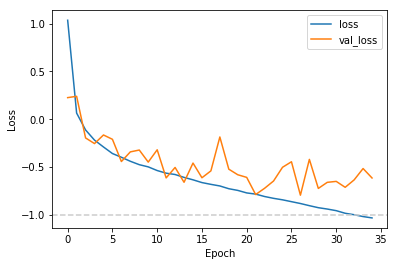

In [111]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.axhline(-1, color='0.8', ls='--')


### Save Model to file

In [112]:
# -----------------
# Define Model Name
# -----------------
model_file = 'data/models/model_{}_{:04d}'
# -----------------

# check if directory needs to be created
model_dir = os.path.dirname(model_file.format(model_name, 0))
if not os.path.exists(model_dir):
    print('Creating Directory {}'.format(model_dir))
    os.makedirs(model_dir)

for i in range(1000):
    model_file_i = model_file.format(model_name, i)
    if not os.path.exists(model_file_i):
        print('Saving prediction to:', model_file_i)
        model.save(model_file_i)
        
        # save normalization model
        meta_file = os.path.join(
            model_file_i, 'normalization.txt')
        with open(meta_file, "w") as text_file:
            text_file.write(sensor_norm_file)
        
        # save meta data
        meta_file = os.path.join(
            model_file_i, 'meta.pkl')
        meta_data = {
            'add_coordinates': add_coordinates,
            'sensor_norm_file': sensor_norm_file,
        }
        with open(meta_file, "wb") as handle:
            pickle.dump(meta_data, handle, protocol=2)
        break


Saving prediction to: data/models/model_coords_0001
INFO:tensorflow:Assets written to: data/models/model_coords_0001/assets


## Evaluate Performance of Model 

#### Create ModelWrapper Instance

In [113]:
from modules.model import ModelWrapper

#model_file_i = 'data/models/model_test_0000'

model_wrapper = ModelWrapper(model_file_i)


Loaded Model with settings:
	add_coordinates: True
	sensor_norm_file: data/normalization/sensor_normalization_eqTrue_trTrue.pkl


#### Run Evaluation

In [114]:
from modules.model import likelihood, postprocess

for normalized in [True]:
    for run in range(7, 9):
        print('Creating Run {} with normalization {}'.format(
            run, normalized))
        
        # get data
        t_data = np.array(t_list[run])
        X_data = np.array(X_list[run])
        y_true = np.array(y_list[run])
        
        # limit data and frequency
        num_frames = 100
        start = 0
        every_nth = 2
        t_data = t_data[::every_nth][start:start + num_frames]
        y_true = y_true[::every_nth][start:start + num_frames]
        X_data = X_data[::every_nth][start:start + num_frames]
        
        # run ModelWrapper prediction before we alte the
        # data tensors
        mu_wrapper = model_wrapper.predict(
            X_data, t_data, run_post_processing=True)
        
        X_data = (X_data - sensor_bias) / sensor_std
        X_data[~np.isfinite(X_data)] = 0
        #X_data, y_true = flip_along_y_axis(X_data, y_true)
        #X_data, y_true = shift_columns(X_data, y_true, n=15)
        X_data = X_data[..., 6:]
        
        if add_coordinates:
            X_data = append_vicon_coords(X_data)

        y_pred = model.predict(X_data)

        # undo normalization of y_pred during training
        # y_pred *= 10.
        
        mu = y_pred[..., :2]
        sigma = y_pred[..., 2:4]
        r = y_pred[..., 4:]
        
        # Run Evaluation
        print('Plain Model Prediction')
        print(np.mean(np.sum(np.sqrt((mu - y_true)**2), axis=1)))
        vel, acc = get_vel_and_acc(mu, t_data)[:2]
        print(np.max(vel), np.max(acc))
        
        if False:
            mu = postprocess(mu, sigma, r, t_data, 
                             pre_fitting_size=None)

            # Run Evaluation
            print('After Post-Processing')
            print(np.mean(np.sum(np.sqrt((mu - y_true)**2), axis=1)))
            print(np.mean((mu - y_true)**2))
            vel, acc = get_vel_and_acc(mu, t_data)[:2]
            print(np.max(vel), np.max(acc))
        
        # Run Evaluation
        print('Model Wrapper Class')
        print(np.mean(np.sum(np.sqrt((mu_wrapper - y_true)**2), axis=1)))
        print(np.mean((mu_wrapper - y_true)**2))
        vel, acc = get_vel_and_acc(mu_wrapper, t_data)[:2]
        print(np.max(vel), np.max(acc))
        
        if False:
            create_complete_gif2(
                run, normalized=normalized, num_frames=num_frames,
                y_pred=mu,
            )

Creating Run 7 with normalization True
Mean failed:
[2.68146218 3.01600674 3.52505789 2.1406918  3.1381058  2.29615278
 2.25678697 2.53479515 2.0403078  2.5055971  3.33850411 6.46628583
 3.79982409 2.76148474 2.31269992 2.26963425 3.57022607 2.47796934
 3.27114181 3.764141   2.59755588 2.89662666 2.4421366  2.34885581
 2.10768783 4.79910271 3.04441256 2.03106906 4.8108747  2.16208966
 3.51157257 2.13824155 2.93782786 3.05334724 2.6985577  2.92546061
 2.99357862 3.83793383 2.13453082 6.46628583 6.46628583 3.61137568
 6.46628583]
Std failed:
[0.00000000e+00 8.32667268e-17 1.38777878e-17 8.32667268e-17
 2.16840434e-18 9.71445147e-17 3.46944695e-18 8.32667268e-17
 8.67361738e-19 6.93889390e-18 5.32907052e-15 5.25504450e-02
 1.98097726e+01 2.01176231e+01 6.00273960e-02 2.03814992e+01
 8.32667268e-17 1.38777878e-17 8.32667268e-17 2.16840434e-18
 9.71445147e-17 3.46944695e-18 8.32667268e-17 8.67361738e-19
 6.93889390e-18 5.32907052e-15 8.32667268e-17 1.38777878e-17
 8.32667268e-17 2.16840434e

      fun: -7.560687561999785
 hess_inv: <200x200 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.61608619e+00, -8.55132498e-01, -2.78833170e+00, -1.39456944e+00,
       -2.04693009e+00, -1.95254302e-01, -1.39331746e-01, -1.21252128e+00,
       -9.85474458e-01, -1.63485652e+00, -7.64612764e+00, -7.25444096e+00,
        1.52470037e+01,  1.24370047e+01, -1.19520067e+01, -7.38012602e+00,
       -1.48754964e+00, -1.94450962e+00, -3.44600295e+00, -2.08931397e+00,
        1.12457599e-01,  1.43577978e+01,  2.16503679e+01,  8.82004972e+03,
        2.72180669e+02,  8.55396713e+03, -1.11269898e+01,  3.47171792e+01,
        1.67993861e+01, -1.12580025e+01, -1.94790459e+00, -3.40138982e+01,
       -1.82930606e+01,  4.54914357e+01,  1.28832795e+01, -2.36000290e+01,
        2.41512694e+01, -4.88758616e+00, -4.63727105e+01,  1.41678001e+01,
        2.03476887e+01, -8.55800408e-01, -1.75060109e+00,  1.07364713e+00,
        3.58423051e+00, -1.19128885e+00, -4.88797980e-01, -4.23804636e+00,

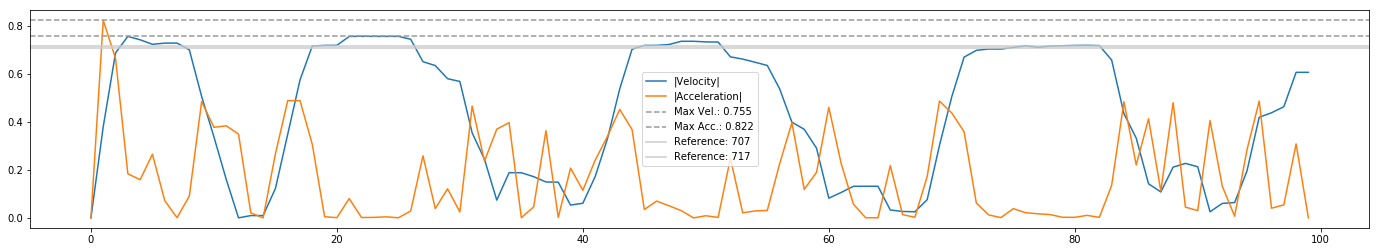

In [115]:
#0.12232663187172524
#0.1542695253008115

# get velocity and acceleration
vel_abs, acc_abs, acc_parallel, acc_perp = \
    get_vel_and_acc(mu_wrapper, t_data)

plt.figure(figsize=(24, 4))
plt.plot(vel_abs, label='|Velocity|')
plt.plot(acc_abs, label='|Acceleration|')
plt.axhline(np.max(vel_abs), ls='--', color='0.6', 
           label='Max Vel.: {:3.3f}'.format(np.max(vel_abs)))
plt.axhline(np.max(acc_abs), ls='--', color='0.6', 
           label='Max Acc.: {:3.3f}'.format(np.max(acc_abs)))
plt.axhline(.707, ls='-', color='.8', label='Reference: 707')
plt.axhline(.717, ls='-', color='.8', label='Reference: 717')
plt.legend()
plt.show()

### Run Prediction on Test Data

In [116]:
test_file = 'data/summerschool2020/Robot_Data/test/test_data.csv'

frames_test, y_test, t_test, X_test = read_data(test_file)

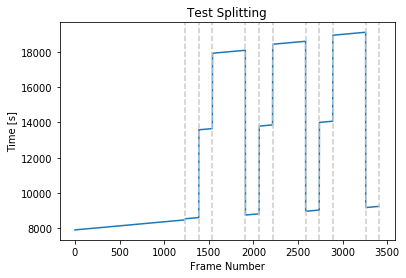

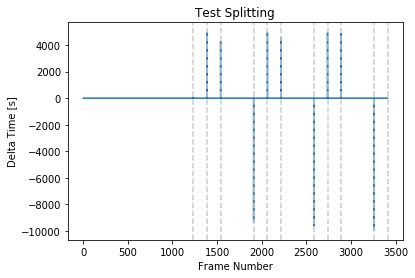

In [117]:
dt = np.diff(t_test, axis=0)
indices = np.arange(len(dt)) + 1
mask = np.abs(dt[:, 0]) > 3
break_indices = np.append(indices[mask], len(t_test))

plt.title('Test Splitting')
plt.plot(t_test)
for b in break_indices:
    plt.axvline(b, color='0.8', ls='--')
#plt.xlim(break_indices[1]-2, break_indices[1]+2)
plt.ylabel('Time [s]')
plt.xlabel('Frame Number')
plt.show()

plt.title('Test Splitting')
plt.plot(dt)
for b in break_indices:
    plt.axvline(b, color='0.8', ls='--')
plt.ylabel('Delta Time [s]')
plt.xlabel('Frame Number')
plt.show()


#### Seperate test data in coherent chunks

0 1235
0 154
0 152
0 370
0 154
0 151
0 370
0 153
0 151
0 369
0 153


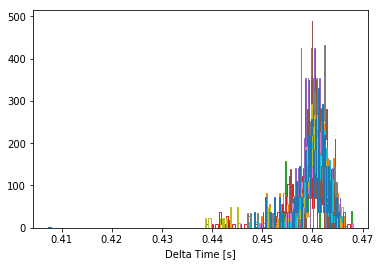

In [118]:
frames_test_list = []
y_test_list = []
t_test_list = []
X_test_list = []

last_index = 0
for b in break_indices:
    y_test_list.append(y_test[last_index:b])
    t_test_list.append(t_test[last_index:b])
    X_test_list.append(X_test[last_index:b])
    frames_test_list.append(frames_test[last_index:b])
    
    plt.hist(np.diff(t_test_list[-1], axis=0), bins=100,
             density=True, histtype='step')
    print(np.sum(np.diff(t_test_list[-1], axis=0)>3),
          len(t_test_list[-1]))
    
    last_index = b

assert len(X_test) == np.sum([len(t) for t in X_test_list])

plt.xlabel('Delta Time [s]')
plt.show()

In [119]:
num_frames = 100
use_wrapper = True

y_test_pred = []

for split in tqdm(range(len(X_test_list))):
    X_test_i = np.array(X_test_list[split])
    t_test_i = np.array(t_test_list[split])
    y_test_i = np.array(y_test_list[split])
    
    if use_wrapper:
        mu = model_wrapper.predict(X_test_i, t_test_i)
    else:

        X_test_norm_i = np.array((X_test_i - sensor_bias) / sensor_std)
        X_test_norm_i[~np.isfinite(X_test_norm_i)] = 0
        X_test_norm_i = X_test_norm_i[..., 6:]

        y_test_pred_i = model.predict(X_test_norm_i)

        mu = y_test_pred_i[..., :2]
        sigma = y_test_pred_i[..., 2:4]
        r = y_test_pred_i[..., 4:]

        # Run Evaluation
        vel, acc = get_vel_and_acc(mu, t_test_i)[:2]
        print(np.max(vel), np.max(acc))

        mu = postprocess(mu, sigma, r, t_test_i, 
                         pre_fitting_size=None)

    # Run Evaluation
    vel, acc = get_vel_and_acc(mu, t_test_i)[:2]
    print(np.max(vel), np.max(acc))
    
    # append reconstructed positions to list
    y_test_pred.append(mu)
    
    
y_test_pred = np.concatenate(y_test_pred, axis=0)

if False:
    create_complete_gif2(
        run, 
        file_name='plots/gif_test_{norm}.gif',
        normalized=True, num_frames=num_frames,
        y_pred=y_test_pred,
    )

Mean failed:
[3.02235674 3.12472669 2.43742043 2.00598736 6.46628583 2.15410571
 2.10145191 3.48779076 2.00805161 2.79001164 4.2094556  6.46628583
 6.46628583 6.46628583]
Std failed:
[3.41393580e-15 1.23512311e-15 6.59194921e-16 2.25514052e-17
 3.88578059e-16 4.44089210e-16 1.73472348e-16 4.64038530e-17
 7.42461648e-16 9.85878046e-14 3.41393580e-15 1.23512311e-15
 6.59194921e-16 2.25514052e-17 3.88578059e-16 4.44089210e-16
 1.73472348e-16 4.64038530e-17 7.42461648e-16 9.85878046e-14
 3.41393580e-15 1.23512311e-15 6.59194921e-16 2.25514052e-17
 3.88578059e-16 4.44089210e-16 1.73472348e-16 4.64038530e-17
 7.42461648e-16 9.85878046e-14 3.41393580e-15 1.23512311e-15
 6.59194921e-16 2.25514052e-17 3.88578059e-16 4.44089210e-16
 1.73472348e-16 4.64038530e-17 7.42461648e-16 9.85878046e-14]
=== Test Failed ===
Mean: [should be around zero]
[ 0.07123664 -0.01938871  0.02713758  0.00494604 -0.02524264 -0.00820842
 -0.0376029   0.02702599  0.002082    0.02894311]

Std: [should be around 1]
[0.113

      fun: 14.20573803500534
 hess_inv: <304x304 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.44750913e+01,  1.81538269e+01, -2.07556610e+01, -2.45874560e+01,
        1.14985511e+01, -1.02213392e+01,  4.65632866e-02,  1.59934444e+01,
        1.51675437e+01, -2.40294952e+01,  1.53718493e+03, -3.83430129e+03,
       -1.54359316e+03,  3.84844203e+03, -2.98701934e+00,  5.85180260e+00,
        1.66624261e+00,  1.80785662e+00,  6.93561617e+00, -1.10970575e+00,
       -8.73457395e+00,  2.05899937e+00,  3.91915222e+01, -4.68946553e+00,
       -3.94401525e+01,  6.59960619e-01,  1.20349711e+01, -1.66752159e+00,
        2.90883293e+01,  1.02850095e+01, -6.89656758e+01, -3.32879097e+01,
        2.75087359e+01,  8.32817193e+00,  5.65379978e+02, -2.98431303e+01,
        9.64791099e+02,  4.19908969e+02, -3.77929155e-01,  1.66437530e+00,
        3.64694017e+00,  1.15800276e+01, -2.88419244e+00, -1.42776344e+01,
        5.60159492e+00,  7.47854472e+00,  2.46453851e+01, -2.22397091e+01,


/home/mirco/Downloads/notebooks/2020_sfb_summerschool/modules/model.py:773: RuntimeWarning: overflow encountered in exp
  np.exp(0 + reg_hard*acc_abs),
/home/mirco/Downloads/notebooks/2020_sfb_summerschool/modules/model.py:774: RuntimeWarning: overflow encountered in exp
  np.exp(offset + reg_soft*acc_abs),
/home/mirco/Downloads/notebooks/2020_sfb_summerschool/modules/model.py:799: RuntimeWarning: overflow encountered in exp
  np.exp(10*(vel_abs - max_cut_off)),
/home/mirco/virtualenv/tensorflow2_python3/lib/python3.5/site-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  df = (f(*((xk + d,) + args)) - f0) / d[k]


      fun: -20.095420183491683
 hess_inv: <740x740 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.53578412e+00,  9.54969437e-04,  9.38490530e-01,  2.33989681e+00,
       -9.68645963e-01, -6.31351895e+00,  9.56709982e+00, -1.45625677e+01,
       -1.09332404e+01,  2.47854871e+01,  9.58937107e-01, -9.79850370e+00,
        2.00552108e+00, -1.22932761e+01, -3.75074478e+00,  1.36016070e+00,
        4.97217343e+00,  5.72264298e+00,  9.53140216e+00, -2.27054784e+00,
       -1.72391765e+01,  1.74372872e-01,  7.97452913e+00,  3.42699877e+00,
        1.66862719e+00, -1.37508437e+01,  1.40198608e-01,  3.11441113e+01,
       -1.82479880e+00, -2.23668451e+01, -5.08180165e-01, -3.07341566e+00,
       -4.65358880e+00,  3.24330358e+00, -5.35156346e+00,  5.47721015e+00,
        6.85146802e+00, -1.31041361e+01, -1.19414381e+00,  1.95637710e+01,
        1.59117235e+01, -1.88554168e+01, -3.09401003e+00, -2.48898004e+00,
        3.13538067e+00, -2.01775265e+01, -7.86932333e+00,  3.11460440e+01

      fun: 5.065742719343348
 hess_inv: <308x308 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.62582126e+00,  3.35728600e-01, -4.65445851e+00, -1.19583774e+00,
        2.90752951e+00,  1.70439364e+01, -1.18587138e+01, -2.20229907e+01,
       -1.78639567e+01, -1.23301021e+01,  2.98369429e+01,  1.46899652e+01,
       -9.45100282e+00, -4.81534812e+00,  1.47809374e+00,  3.14067847e+00,
       -5.67113716e+00, -1.71001489e+01,  1.45506249e+01,  5.62345974e+01,
       -1.16371496e+01, -5.46457670e+01,  2.58894488e+00,  9.95685525e+00,
        3.31103820e+00,  1.44302419e+01, -1.08938707e+00, -1.08176096e+01,
        5.70949510e-01, -2.34716140e+00,  6.35751007e-01,  3.66584629e+00,
       -3.85114163e-02, -2.48903973e+00, -6.60523938e+00,  2.25210215e+00,
        1.51801771e+00, -1.23009158e-01, -3.30920784e+00,  1.07860387e-01,
        1.09573079e+01,  4.30106297e+00, -1.12055773e+01, -1.19141163e+01,
        9.43225018e+00,  4.40098233e+00, -1.34173774e+00, -1.90924538e+00,


      fun: -13.162793833326162
 hess_inv: <302x302 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.04143839e+00, -1.44915333e+01, -5.00560304e-01,  2.46094061e+01,
       -1.07057048e+01, -4.83143197e+00,  8.86659564e+00, -1.03107396e+01,
        6.15351894e+00, -6.38328004e+00,  1.11621432e+00,  9.46263015e+00,
       -1.43026398e+01, -2.00522749e+01,  1.97886010e+01,  5.12141952e+01,
        3.00923853e+02,  6.57269982e+02, -3.11250292e+02, -6.84429151e+02,
        9.27502128e+00, -1.80561187e+01,  1.20116113e+00,  7.95586459e+00,
       -1.22056349e+01,  1.72430248e+00, -4.16049772e+00,  6.59502177e+00,
        1.05578380e+01, -7.71930786e-01, -2.85732540e+00, -1.60862044e+00,
       -2.49829810e+01, -1.68100627e+01,  3.87901281e+01,  1.47117078e+01,
        2.77780146e+00, -3.99757596e+00, -2.88156230e+01, -6.09921358e-01,
        1.58471494e+01,  8.22035133e+00, -8.83133566e+00, -4.69444785e+00,
       -2.97868041e-01,  1.62540630e+00,  7.91169157e+00, -1.11661990e+01

      fun: 9.155728406707624
 hess_inv: <740x740 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.77591016e+00,  9.75406920e+00,  6.40823146e+00, -2.73892340e+01,
       -5.92698939e+00,  3.28657677e+01, -5.46251044e+00, -1.96554822e+01,
        1.36376798e+01,  4.93229777e+00, -1.49615346e+01, -4.11483256e+00,
        3.89324555e+00,  1.07213680e+01,  1.36161702e+01,  2.22934204e-01,
        5.07175741e+00, -2.89229661e+01, -1.35110668e+01,  2.38561597e+01,
        6.58389467e+00, -6.23232950e+00, -3.83474799e+00,  1.05887352e+01,
        3.18585194e+00, -2.25035365e+01, -5.13005602e+00,  9.90887656e+00,
        1.04128560e+01,  2.31988167e+01, -9.05607180e+00, -3.24013570e+01,
        4.60814249e+00,  8.29911642e+00,  2.25602435e+00, -2.30431283e+00,
       -3.46817615e+00, -2.37285462e+00, -4.39837891e+00,  1.25875488e+01,
        1.78357709e+01, -5.24060511e+00, -1.56934277e+01, -9.04327067e+00,
       -3.47363880e+00, -3.84492864e+00, -2.14794227e-01,  1.33873641e+00,


      fun: 16.71760800450315
 hess_inv: <306x306 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 9.26681309e-01,  8.36690504e+00, -1.63176139e+00,  6.40190478e-01,
        8.15248313e-02, -2.26945360e+00,  1.25604060e-01, -7.91635273e+00,
        1.23320092e+00,  2.33622472e+00, -1.71295085e+00,  8.87419560e-01,
        1.24284014e+01,  4.43605757e+00, -2.60277773e+00, -1.03532074e+01,
       -1.64208217e+01,  5.84041402e+00, -9.81316362e-02, -2.25130975e+01,
       -1.75673165e+00,  2.49455439e+01,  3.44555815e+00, -1.23760373e+01,
        2.92346556e+00,  8.46711146e-02,  2.23024585e+00,  1.79145161e+00,
       -3.30800560e+00,  2.32518858e+00, -5.59421665e-01,  4.69306372e+00,
        5.86956617e-01, -3.12394661e+00, -8.95742372e+02, -1.00241677e+03,
        8.99996678e+02,  1.01591237e+03, -1.20898562e+01, -3.71150378e+01,
        7.02527814e+00,  2.09673289e+01,  4.56401494e-01,  8.31099101e+00,
        7.64146080e-02, -7.84251597e+00, -9.79397896e-01, -1.71300485e-01,


      fun: 1.0181580503661394
 hess_inv: <302x302 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.31874174e+00, -5.17115666e+00,  3.89249806e+00, -5.63096307e+00,
        1.66304517e+00, -5.61234970e-01, -3.91225967e+00,  1.23996813e+01,
        1.59147078e+00,  3.23232143e+00,  1.80658333e+00,  5.81082702e+00,
        4.16290789e+00, -1.02178120e+01, -1.00795091e+01,  7.68599193e+00,
        3.04820560e+00, -1.55103265e+01, -1.99495958e+01,  7.92877302e+00,
        1.82158459e+01, -7.06253900e-01, -2.55595012e+00, -6.77425760e-01,
       -6.98878182e+00,  1.56607882e+00,  5.95889844e+00, -7.02538898e+00,
       -1.27076618e+01,  1.59145401e+01,  1.14677761e+01, -2.57974847e+01,
        1.49285853e+01, -2.13863984e+00, -1.66242046e+01,  1.37872547e+01,
        1.38285543e+00,  2.37009289e+01, -3.34418644e+00, -3.18499559e+01,
        4.93986363e-01,  5.78242805e+00,  7.00310920e-01, -1.32509058e+01,
       -2.35616824e+00,  1.10433774e+01,  8.73220074e-01, -5.14160376e+00,

      fun: 41.32605790209391
 hess_inv: <738x738 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.35169169e+00,  4.09133349e+00, -4.71168846e+00,  2.75043135e+00,
        2.63024162e+00, -4.64841605e+00, -9.65389972e+00,  4.74697117e+00,
        5.36419975e-01,  9.99204985e-01, -7.60888952e-01, -3.55040925e+01,
        4.89829404e+00,  3.01492832e+01, -1.06379218e+01, -7.94175889e+00,
        4.71069939e+00, -4.59289140e+00,  9.09716960e+00,  7.62325385e+00,
       -6.78314223e+00, -1.15647879e+01,  8.59596980e+00,  3.61321781e+00,
       -5.40552492e-01,  2.89062996e+00, -5.11135454e+00, -8.64588401e-03,
       -5.17258059e-01, -4.35800359e+01,  4.44009629e-01, -1.23350361e+02,
        2.22761969e+00,  1.68280911e+02, -1.08128120e+00, -3.75113132e+00,
       -3.57208023e+00, -2.84390467e+00,  3.52719098e-01,  4.68613734e+00,
        2.60545789e+00, -1.76682420e+00, -3.52884513e+00,  6.18700255e+00,
        6.60913315e+00, -2.09139102e+01, -3.81401719e+00, -3.72466502e-01,


      fun: -35.90292748715228
 hess_inv: <306x306 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.89405510e+00,  1.00863787e+01,  8.61537899e+00, -1.16571073e+00,
       -4.46216859e+00, -2.08825554e+01,  2.46536160e+00,  1.12720613e+01,
        3.58841135e-01, -5.14357339e+00,  3.53986707e-01,  1.08762862e+01,
        2.99712610e-01, -2.58450257e+00, -3.62553010e-01,  9.70834435e-01,
       -2.29039756e+00, -7.32132435e+00,  2.45286458e+00, -1.28184553e+01,
       -6.06202093e+00,  3.36076198e+01,  4.02828277e+00, -1.52291108e+01,
       -2.57914792e+00, -1.70733188e+00, -6.35066044e-01,  1.11597842e-01,
       -4.33715286e-02,  4.75637876e+00,  4.21725588e+00, -1.02588757e+01,
       -1.01876566e+01, -8.43463681e+00, -1.73970534e+01,  2.64473584e+01,
        7.61947092e+00, -1.95614405e+01,  1.18711199e+01,  3.62529676e+01,
       -1.99844436e+01, -6.64768550e+01,  3.67815858e+01,  1.94456504e+01,
       -6.01022407e+01,  6.09667268e+00,  3.60463730e+01, -6.02606178e+00,

In [120]:
print(len(y_test_pred), len(X_test))
assert len(y_test_pred) == len(X_test), len(y_test_pred)

data_dict = {
    'frame_number': range(len(y_test_pred)),
    'vicon_x': y_test_pred[:, 0],
    'vicon_y': y_test_pred[:, 1],
}

df_test_pred = pd.DataFrame(data_dict)
df_test_pred = df_test_pred.set_index('frame_number')
print(df_test_pred.head())

test_pred_file = 'data/test_submission_{}_{:03d}.csv'
for i in range(1000):
    test_pred_file_i = test_pred_file.format(
        os.path.basename(model_file_i), i)
    if not os.path.exists(test_pred_file_i):
        print('Saving prediction to:', test_pred_file_i)
        df_test_pred.to_csv(test_pred_file_i)
        break

3412 3412
               vicon_x   vicon_y
frame_number                    
0            -9.837687 -1.631393
1            -9.860303 -1.574874
2            -9.889053 -1.504100
3            -9.890236 -1.500499
4            -9.888081 -1.452220
Saving prediction to: data/test_submission_model_coords_0001_000.csv


#### Check Resolution

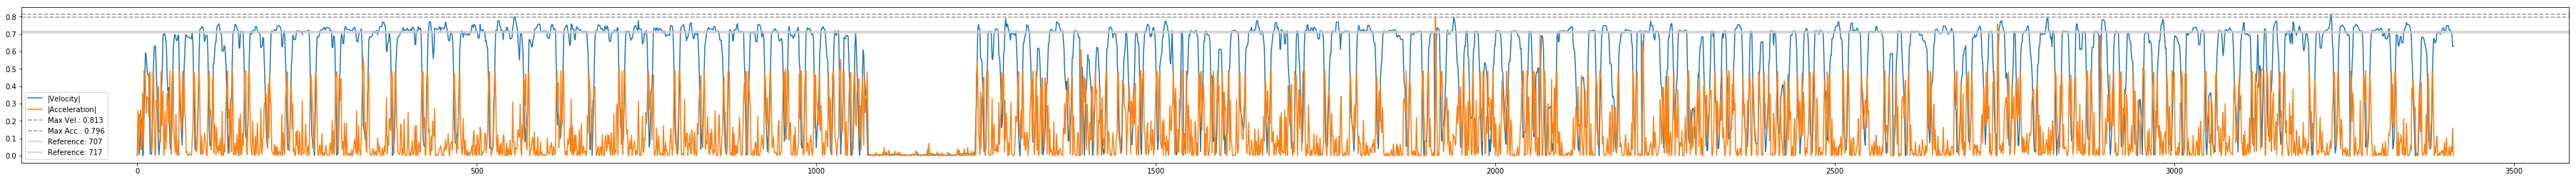

In [121]:
t_test_pred = []
for split in tqdm(range(len(X_test_list))):
    t_test_i = np.array(t_test_list[split])
    t_test_pred.append(t_test_i)
t_test_pred = np.concatenate(t_test_pred, axis=0)

# get velocity and acceleration
vel_abs, acc_abs, acc_parallel, acc_perp = \
    get_vel_and_acc(y_test_pred, t_test_pred)

plt.figure(figsize=(64, 4))
plt.plot(vel_abs, label='|Velocity|')
plt.plot(acc_abs, label='|Acceleration|')
plt.axhline(np.max(vel_abs), ls='--', color='0.6', 
           label='Max Vel.: {:3.3f}'.format(np.max(vel_abs)))
plt.axhline(np.max(acc_abs), ls='--', color='0.6', 
           label='Max Acc.: {:3.3f}'.format(np.max(acc_abs)))
plt.axhline(.707, ls='-', color='.8', label='Reference: 707')
plt.axhline(.717, ls='-', color='.8', label='Reference: 717')
plt.legend()
plt.show()
    

/home/mirco/virtualenv/tensorflow2_python3/lib/python3.5/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


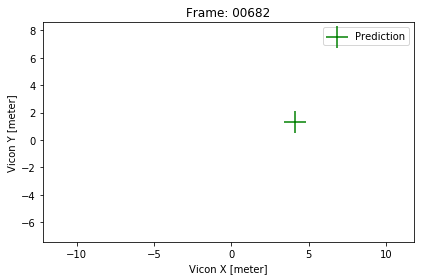

In [122]:
create_y_gif(
    y_pred=y_test_pred[::5], 
    y_true=None, 
    file_name='plots/gif_y_prediction.gif')

## Predict with 3D CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from egenerator.utils import basis_functions

In [ ]:
def limit_sigma(y_pred):
    mu = y_pred[..., :2]
    sigma = y_pred[..., 2:]
    sigma = tf.nn.elu(sigma) + 1.001
    y_pred = tf.concat([mu, sigma], axis=-1)
    return y_pred

n_previous = 10

model3d = models.Sequential()
model3d.add(layers.Conv3D(8, (3, 3, 1), activation='elu', 
                        padding='same',
                        input_shape=(23, 15, n_previous, 4)))
model3d.add(layers.Conv3D(16, (3, 3, 1), activation='elu', 
                        padding='same'))
model3d.add(layers.MaxPooling3D((2, 2, 1)))
model3d.add(layers.Conv3D(16, (3, 3, 1), activation='elu',
                        padding='same'))
model3d.add(layers.Conv3D(16, (1, 1, 5), activation='elu',
                        padding='same'))
model3d.add(layers.MaxPooling3D((2, 2, 2)))
model3d.add(layers.Conv3D(16, (3, 3, 1), activation='elu',
                        padding='same'))
model3d.add(layers.Conv3D(16, (3, 3, 1), activation='elu',
                        padding='same'))
model3d.add(layers.Conv3D(16, (1, 1, 5), activation='elu',
                        padding='same'))
model3d.add(layers.MaxPooling3D((2, 2, 2)))
model3d.add(layers.Flatten())
model3d.add(layers.Dense(64, activation='elu'))
model3d.add(layers.Dense(6))    
model3d.add(layers.Lambda(limit_sigma))
model3d.summary()

In [ ]:
def loss_fun(y_true, y_pred):
    mu = y_pred[..., :2]
    sigma = y_pred[..., 2:4]
    r = y_pred[..., 4:6]
    loss = tf.reduce_mean(
        -basis_functions.tf_log_asymmetric_gauss(
            y_true, mu=mu, sigma=sigma, r=r)
    )
    #loss = tf.reduce_mean(
    #    -basis_functions.tf_log_gauss(
    #        y_true, mu=mu, sigma=sigma)
    #)
    #loss = tf.reduce_sum((y_true - y_pred)**2)
    return loss

model3d.compile(optimizer='adam', loss=loss_fun)

In [ ]:
def get_3d_train_data(run):
    X = np.array(X_list[run])
    X = (X - sensor_bias) / sensor_std
    X[~np.isfinite(X)] = 0
    y = np.array(y_list[train_index])
    
    # Now add in time dimension with previous n steps
    X_train3d = np.zeros(
        list(X.shape) + [n_previous])
    for i in range(n_previous):
        if i == 0:
            X_train3d[..., i] = X
        else:
            X_train3d[i:, ..., i] = X[:-i]

    X_train3d = np.transpose(X_train3d, axes=[0, 1, 2, 4, 3])
    return X_train3d, y

X_train_list = []
y_train_list = []
for train_index in range(8):
    X_train3d, y = get_3d_train_data(train_index)
    X_train_list.append(X_train3d[..., 6:])
    y_train_list.append(y)
    
X_train3d = np.concatenate(X_train_list, axis=0)
y_train3d = np.concatenate(y_train_list, axis=0)
print('X_train3d',X_train3d.shape)

In [ ]:
history = model3d.fit(
    x=X_train3d, y=y_train3d, epochs=20, 
    validation_split=0.05)

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [ ]:

for normalized in [True]:
    for run in range(7, 9):
        print('Creating Run {} with normalization {}'.format(
            run, normalized))
        
        X_test, y_true = get_3d_train_data(run)
        
        y_pred = model3d.predict(X_test[..., 6:])
        
        num_frames = 100
        y_true = y_true[:num_frames]
        y_pred = y_pred[:num_frames]
        
        mu = y_pred[..., :2]
        sigma = y_pred[..., 2:4]
        r = y_pred[..., 4:]
        
        # Run Evaluation
        print(np.mean(np.sum(np.sqrt((mu - y_true)**2), axis=1)))
        vel, acc = get_vel_and_acc(mu)
        print(np.max(vel), np.max(acc))
    
        mu = postprocess(mu, sigma, r)
        
        # Run Evaluation
        print(np.mean(np.sum(np.sqrt((mu - y_true)**2), axis=1)))
        vel, acc = get_vel_and_acc(mu)
        print(np.max(vel), np.max(acc))
        
        if False:
            create_complete_gif2(
                run, normalized=normalized, num_frames=100,
                y_pred=mu,
            )